<a href="https://colab.research.google.com/github/denvercodernine/intro_nlp_article_classification/blob/main/scikit_naive_bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup**
1.   Importing modules
2.   Mounting persistent storage

In [ ]:
import matplotlib.pyplot as plt
import re

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
!ln -s '/gdrive/My Drive/ArticleClassification' '/content/storage'

# **Loading raw data**

In [ ]:
import pandas as pd

df = pd.read_csv(open("/content/storage/rawdata.csv", encoding='utf-8'))
cat = pd.read_csv(open("/content/storage/categories.csv", encoding='utf-8'))

In [ ]:
df = df[df.catidbase.isin(cat.cat_id)]
df.head()

,catid,catidbase,catidlist,content,description,postid,tags,title,url,writtenOn
0,1001005,1001005,"1000000,1001005",Trung tâm Dự báo Khí tượng Thủy văn quốc gia ...,Tin bão xa một cơn bão khác tên quốc tế Atsa...,4188067,NaN,Bão mạnh cấp 10 gần Biển Đông,https://vnexpress.net/bao-manh-cap-10-gan-bien...,"Thứ sáu, 6/11/2020, 18:22 (GMT+7)"
1,1001142,1001002,"1000000,1001002,1001142",Các nỗ lực hòa giải sau bầu cử tổng thống Mỹ ...,Trump có thể theo đuổi cuộc chiến pháp lý hoặc...,4189943,NaN,Những kịch bản có thể xảy ra khi Trump không n...,https://vnexpress.net/nhung-kich-ban-co-the-xa...,"Thứ tư, 11/11/2020, 20:00 (GMT+7)"
2,1001002,1001002,"1000000,1001002",Trang ngày 10/11 dẫn một nguồn tin giấu tên t...,Trump có thể nhận được những lời chào mời về h...,4190431,NaN,Trump có thể kiếm 100 triệu USD hậu Nhà Trắng ...,https://vnexpress.net/trump-co-the-kiem-100-tr...,"Thứ tư, 11/11/2020, 20:36 (GMT+7)"
3,1001139,1001002,"1000000,1001002,1001139",Truyền thông Mỹ hôm 7/11 xướng tên ứng viên đả...,Trump đang thúc đẩy các thách thức pháp lý nhằ...,4190259,NaN,5 mặt trận pháp lý bầu cử Trump khởi xướng - V...,https://vnexpress.net/5-mat-tran-phap-ly-bau-c...,"Thứ tư, 11/11/2020, 21:00 (GMT+7)"
4,1001005,1001005,"1000000,1001005",Ngày 5/11 Hội nghị Tư lệnh Hải quân các nước ...,Sáng kiến quot cơ chế hợp tác trao đổi kinh ...,4187610,NaN,Tư lệnh Hải quân ASEAN trao đổi kinh nghiệm hu...,https://vnexpress.net/tu-lenh-hai-quan-asean-t...,"Thứ năm, 5/11/2020, 22:24 (GMT+7)"


In [ ]:
cat.head()

,cat_id,cat_name
0,1001005,Thời sự
1,1001002,Thế giới
2,1003159,Kinh doanh
3,1002691,Giải trí
4,1002565,Thể thao


In [ ]:
df.count()

catid          1418
catidbase      1418
catidlist      1418
content        1418
description    1418
postid         1418
tags              0
title          1418
url            1418
writtenOn      1418
dtype: int64

In [ ]:
df['catidbase'].count()

1418

# **Cleaning raw data**

In [ ]:
punctuation = [r'!',  r'&', r'-', r'\/', r'\\',
               r'(', r')', r'*', r'+', r',', u':', u';', u'=', u'>', u'?', u'.']

def clean_text(text):
  for punc in punctuation:
    text = text.replace(punc, ' ')
  text = text.replace('VnExpress', '')
  text = re.sub(r'[0-9]+', '', text)
  return text

df['text'] = df.title + " " + df.description + " " + df.content
df['text'] = df['text'].apply(clean_text)

In [ ]:
df['len_text'] = df.text.apply(lambda i: len(i))

In [ ]:
df['len_text'].describe()

count     1418.000000
mean      2655.394217
std       1775.483892
min        271.000000
25%       1503.500000
50%       2136.000000
75%       3347.750000
max      12201.000000
Name: len_text, dtype: float64

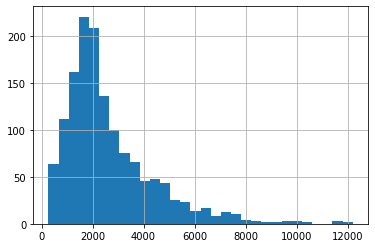

In [ ]:
df.len_text.hist(bins=30)

# **Scikit naive bayes**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import numpy as np
import pickle

#https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

#GET VECTOR COUNT
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(df.text)

#SAVE WORD VECTOR
pickle.dump(count_vect.vocabulary_, open("/content/storage/count_vector.pkl","wb"))

In [ ]:
#TRANSFORM WORD VECTOR TO TF IDF
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#SAVE TF-IDF
pickle.dump(tfidf_transformer, open("/content/storage/tfidf.pkl","wb"))

In [ ]:
#clf = MultinomialNB().fit(X_train_tfidf, training_data.flag)
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, df.catidbase, test_size=0.25, random_state=42)
clf = MultinomialNB().fit(X_train, y_train)

#SAVE MODEL
pickle.dump(clf, open("/content/storage/nb_model.pkl", "wb"))

In [ ]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

# **Testing**

**Imports**

In [ ]:
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

**Load in models**

In [ ]:
loaded_vec = CountVectorizer(vocabulary=pickle.load(open("/content/storage/count_vector.pkl", "rb")))
loaded_tfidf = pickle.load(open("/content/storage/tfidf.pkl","rb"))
loaded_model = pickle.load(open("/content/storage/nb_model.pkl","rb"))

In [ ]:
cat_dict = cat.set_index('cat_id').to_dict()[' cat_name']

**Predict a news title**

In [ ]:
docs_new = "Khẩu hiệu 'Chúng ta là một', CLB Sài Gòn chỉ nói cho vui?"
docs_new = [docs_new]

X_new_counts = loaded_vec.transform(docs_new)
X_new_tfidf = loaded_tfidf.transform(X_new_counts)
predicted = loaded_model.predict(X_new_tfidf)
print(cat_dict[int(predicted)])

Thể thao


**Predict the test dataset** (uncomment to show results)

In [ ]:
predicted = loaded_model.predict(X_test)
result_bayes = pd.DataFrame( {'true_labels': y_test,'predicted_labels': predicted})
result_bayes.to_csv('res_bayes.csv', sep = ',')
'''
for predicted_item, result in zip(predicted, y_test):
    print(cat_dict[predicted_item], ' - ', cat_dict[result])
'''

"\nfor predicted_item, result in zip(predicted, y_test):\n    print(cat_dict[predicted_item], ' - ', cat_dict[result])\n"

In [ ]:
y_pred_prob = nb.predict_proba(X_test)[:,1]

**Confusion matrix**

In [ ]:
print(confusion_matrix(y_test, predicted))

[[32  0  0  0  0  0  0  0  0  0  0]
 [ 0 26  1  0  0  0  0  7  0  0  1]
 [ 3  2 31  0  0  0  1  2  0  0  0]
 [ 4  2  0  8  0  0  2  5  0  0  1]
 [ 0  0  0  0 30  0  0  1  0  0  0]
 [ 3  0  0  0  0 18  5  7  0  0  0]
 [ 1  0  0  0  0  0 29  1  1  0  0]
 [ 2  1  0  0  0  0  0 27  0  0  0]
 [ 4  3  0  1  0  0  1  3 20  0  0]
 [ 1  3  0  0  0  0  8  1  0 20  0]
 [ 6  1  0  0  0  0  2  0  0  0 27]]


**Report**

In [ ]:
cat

,cat_id,cat_name
0,1001005,Thời sự
1,1001002,Thế giới
2,1003159,Kinh doanh
3,1002691,Giải trí
4,1002565,Thể thao
5,1001007,Pháp luật
6,1003497,Giáo dục
7,1003750,Sức khỏe
8,1002966,Đời sống
9,1003231,Du lịch


In [ ]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

     1001002       0.57      1.00      0.73        32
     1001005       0.68      0.74      0.71        35
     1001007       0.97      0.79      0.87        39
     1001009       0.89      0.36      0.52        22
     1002565       1.00      0.97      0.98        31
     1002691       1.00      0.55      0.71        33
     1002966       0.60      0.91      0.72        32
     1003159       0.50      0.90      0.64        30
     1003231       0.95      0.62      0.75        32
     1003497       1.00      0.61      0.75        33
     1003750       0.93      0.75      0.83        36

    accuracy                           0.75       355
   macro avg       0.83      0.75      0.75       355
weighted avg       0.83      0.75      0.76       355

